## Set up the drive path

In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [8]:
ls

adc.json  datalab@  drive/  sample_data/


In [9]:
cd drive/DCNN_300_dropout_08

/content/drive/DCNN_300_dropout_08


## Import Library

In [0]:
import collections
import os
import sys

import tensorflow as tf
import numpy as np

from tensorflow.contrib.seq2seq import sequence_loss

import math
import re
import matplotlib.pyplot as plt

import pickle

!pip install -q mosestokenizer
from mosestokenizer import *

from nltk.translate.bleu_score import sentence_bleu


from scipy.stats import multivariate_normal
from scipy.stats import norm
import copy

## Data Pre-processing

In [0]:
## load vocab dict from txt file

f = open("../dictionary/en_word_to_id.txt", "rb")
en_word_to_id = pickle.load(f)
f.close()

f = open("../dictionary/fr_word_to_id.txt", "rb")
fr_word_to_id = pickle.load(f)
f.close()

In [12]:
en_vocab_size = len(en_word_to_id)
fr_vocab_size = len(fr_word_to_id)

en_eos = en_word_to_id['eos']
fr_eos = fr_word_to_id['eos']

print(en_vocab_size)
print(fr_vocab_size)

30772
39578


In [0]:
def _read_words(filename):
  with tf.gfile.GFile(filename, "r") as f: 
    output = f.read().replace("\n", " eos ").replace(".", " .")
    output = re.sub('[0-9]+', 'N', output)
    return output

def _file_to_word_ids(data, word_to_id):
  
  id_list = []
  
  for word in data:
    if word in word_to_id:
      id_list.append(word_to_id[word])
    else:
      id_list.append(1)
          
  return id_list


def preprocess_train_data(pre_data, word_to_id, max_length):
    pre_data_array = np.asarray(pre_data)
    last_start = 0
    data = []
    each_sen_len = []
    
    for i in range(len(pre_data_array)):
        if pre_data_array[i]==word_to_id['eos']:
            if max_length >= len(pre_data_array[last_start:(i+1)]):                
              data.append(pre_data_array[last_start:(i+1)])
              each_sen_len.append(i+1-last_start)              
            else:
              shorten_sentences = pre_data_array[last_start:(last_start+max_length-1)]
              shorten_sentences = np.concatenate((shorten_sentences, np.asarray([word_to_id['eos']])), axis=0)
              data.append(shorten_sentences)
              each_sen_len.append(max_length) 
            
            last_start = i+1
            
    out_sentences = np.full([len(data), max_length], word_to_id['<PAD>'], dtype=np.int32)
    for i in range(len(data)):
        out_sentences[i,:len(data[i])] = data[i]    
    return out_sentences, np.asarray(each_sen_len)

In [0]:
def generate_input_en(en_file, en_word_to_id, max_length):
  
    en_data = _read_words(en_file)

    en_tokenize = MosesTokenizer('en')

    en_data = en_tokenize(en_data)

    en_data_id = _file_to_word_ids(en_data, en_word_to_id)

    en_input, en_input_len = preprocess_train_data(en_data_id, en_word_to_id, max_length)
    
    return en_input, en_input_len
  
  
  
def generate_output_fr(fr_file, fr_word_to_id, max_length):
    
    fr_data = _read_words(fr_file)

    fr_tokenize = MosesTokenizer('fr')

    fr_data = fr_tokenize(fr_data)

    fr_data_id = _file_to_word_ids(fr_data, fr_word_to_id)

    fr_output, fr_output_len = preprocess_train_data(fr_data_id, fr_word_to_id,max_length=30)

    #out_beg_token = fr_word_to_id['<beg>']*np.ones((fr_output.shape[0], 1), dtype=np.int32)

    #fr_output = np.concatenate((out_beg_token, fr_output), axis=1)

    return fr_output,fr_output_len

In [0]:
def batch_producer(raw_data, raw_data_len, batch_size):    
    data_len = len(raw_data)    
    batch_len = data_len // batch_size    
    data = np.reshape(raw_data[0 : batch_size * batch_len, :], [batch_size, batch_len, -1])
    data = np.transpose(data, (1,0,2))
    
    data_length = np.reshape(raw_data_len[0 : batch_size * batch_len], [batch_size, batch_len])
    data_length = np.transpose(data_length, (1,0))
    return data, data_length 

In [0]:
en_oov_id = en_word_to_id['<OOV>']
fr_oov_id = fr_word_to_id['<OOV>']

def dropout_func(decode_input, dropout_prob, oov_id):
  for i in range(decode_input.shape[0]):
    for j in range(decode_input.shape[1]):
        for k in range(1,decode_input.shape[2]):
            if np.random.uniform() > dropout_prob:
                decode_input[i,j,k] = oov_id        
  return decode_input

## Model

In [0]:
###################### define parameters ######################

max_length = 30

batch_size = 100

embed_size = 300

infer_hidden_size = 1000

latent_size = 200

latent_num = 1

In [0]:
# ###################### generate sentence #######################
# batch_size = 1

# latent_num = 100

In [0]:
###################### define placeholder ######################

input_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'input')         # batch_size x max_length

target_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'target')       # batch_size x max_length

in_length_placeholder = tf.placeholder(tf.int32, [batch_size, ], 'in_len')              # batch_size x 1

out_length_placeholder = tf.placeholder(tf.int32, [batch_size, ], 'out_len')            # batch_size x 1

discount_placeholder = tf.placeholder(tf.float32, name='discount')

lr_placeholder = tf.placeholder(tf.float32, name='learn_rate')

input_drop_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'input_drop')   # batch_size x max_length

target_drop_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'target_drop') # batch_size x max_length

if_gene_placeholder = tf.placeholder(tf.bool, name='if_gene')

latent_var_placeholder = tf.placeholder(tf.float32, [latent_num, batch_size, max_length, latent_size], 'la_var')       # batch_size x max_length x latent_size

xavier_initializer = tf.contrib.layers.xavier_initializer()

In [0]:
##################### embedding look-up for input sentences ####################

with tf.variable_scope('en_embedding'):
    en_embedding = tf.get_variable('en_embeding',[en_vocab_size, embed_size], dtype=tf.float32, initializer=xavier_initializer)
    inputs = tf.nn.embedding_lookup(en_embedding, input_placeholder)                      # batch_size x max_length x embed_size
    inputs_drop = tf.nn.embedding_lookup(en_embedding, input_drop_placeholder)                      # batch_size x max_length x embed_size

with tf.variable_scope('fr_embedding'):
    fr_embedding = tf.get_variable('fr_embeding',[fr_vocab_size, embed_size], dtype=tf.float32, initializer=xavier_initializer)
    targets = tf.nn.embedding_lookup(fr_embedding, target_placeholder)                      # batch_size x max_length x embed_size
    targets_drop = tf.nn.embedding_lookup(fr_embedding, target_drop_placeholder)                      # batch_size x max_length x embed_size
    

## 1 Inference Model - Encoder

$q(z_1, z_2, ... , z_T|x,y)$

Similar to the encoder of RNNSearch

In [0]:
#################### Inference model  #######################

encode_inputs = tf.transpose(tf.concat([inputs, targets], axis=2), (1,0,2))

with tf.variable_scope('encode'):
    #basic_cell =tf.contrib.rnn.GRUCell(infer_hidden_size)
    basic_cell = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
    init_state = basic_cell.zero_state(batch_size, tf.float32)
    encode_outputs, encode_state = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell, 
                                                                   cell_bw=basic_cell, 
                                                                   inputs=encode_inputs,                                                                
                                                                   initial_state_fw=init_state,
                                                                   initial_state_bw=init_state,
                                                                   dtype=tf.float32,
                                                                   time_major=True)
#### encode_outputs: max_length x batch_size x infer_hidden_size

en_outputs = tf.concat((encode_outputs[0],encode_outputs[1]),2)                             # max_length x batch_size x 2*infer_hidden_size

en_outputs_tran = tf.transpose(en_outputs, (1,0,2))                                         # batch_size x en_max_length x 2*infer_hidden_size

en_outputs_resh = tf.reshape(en_outputs_tran, (batch_size*max_length, 2*infer_hidden_size)) # batch_size*max_length x 2*infer_hidden_size

In [0]:
# ##################### Inference model  #######################

# ##################### bi-direction lstm of source sentence ######################

# encode_inputs_x = tf.transpose(inputs, (1,0,2))  # en_max_length x batch_size x embed_size
  
# with tf.variable_scope('encode_x'):
#     basic_cell_x = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
#     init_state_x = basic_cell_x.zero_state(batch_size, tf.float32)
#     encode_outputs_x, encode_state_x = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell_x, 
#                                                                        cell_bw=basic_cell_x, 
#                                                                        inputs=encode_inputs_x,
#                                                                        sequence_length=in_length_placeholder,
#                                                                        initial_state_fw=init_state_x,
#                                                                        initial_state_bw=init_state_x,
#                                                                        dtype=tf.float32,
#                                                                        time_major=True)
# #### encode_outputs_x: max_length x batch_size x infer_hidden_size




# ##################### bi-direction lstm of target sentence ######################

# encode_inputs_y = tf.transpose(targets, (1,0,2))  # en_max_length x batch_size x embed_size
  
# with tf.variable_scope('encode_y'):
#     basic_cell_y = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
#     init_state_y = basic_cell_y.zero_state(batch_size, tf.float32)
#     encode_outputs_y, encode_state_y = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell_y, 
#                                                                        cell_bw=basic_cell_y, 
#                                                                        inputs=encode_inputs_y,
#                                                                        sequence_length=out_length_placeholder,
#                                                                        initial_state_fw=init_state_y,
#                                                                        initial_state_bw=init_state_y,
#                                                                        dtype=tf.float32,
#                                                                        time_major=True)
# #### encode_outputs_y: max_length x batch_size x infer_hidden_size


# ##################### concatenate the output of encoder of x and y ######################

# fw_bw_en_outputs_x = tf.concat((encode_outputs_x[0],encode_outputs_x[1]),2)     # en_max_length x batch_size x 2*infer_hidden_size

# fw_bw_en_outputs_y = tf.concat((encode_outputs_y[0],encode_outputs_y[1]),2)     # en_max_length x batch_size x 2*infer_hidden_size

# fw_bw_en_outputs = tf.concat((fw_bw_en_outputs_x, fw_bw_en_outputs_y), 2)       # en_max_length x batch_size x 4*infer_hidden_size

# fw_bw_en_outputs_tran = tf.transpose(fw_bw_en_outputs, (1,0,2))                 # batch_size x en_max_length x 4*infer_hidden_size

# fw_bw_en_outputs_resh = tf.reshape(fw_bw_en_outputs_tran, (batch_size*max_length, 4*infer_hidden_size)) # batch_size*en_max_length x 4*infer_hidden_size


# # la_mean = tf.matmul(fw_bw_en_outputs_resh, W_1) + b_1                              # batch_size*max_length x latent_size 

# # la_log_var = tf.matmul(fw_bw_en_outputs_resh, W_2) + b_2                           # batch_size*max_length x latent_size 
# # la_var = tf.exp(la_log_var)
# # la_std = tf.sqrt(la_var)

# # kl_div_loss = 1 + la_log_var - tf.square(la_mean) - la_var                               # batch_size*max_length x latent_size
# # kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, axis=1)                         # batch_size*max_length x 1
# # kl_div_loss = tf.reshape(kl_div_loss, (batch_size, max_length))                 # batch_size x max_length
# # kl_div_loss = tf.reduce_sum(kl_div_loss, axis=1)

# # #### sample the latent variable z by reparameterization trick

# # eposida = tf.random_normal(tf.shape(la_std), mean=0.0,stddev=1)
# # latent_variables = la_mean + la_std*eposida
# # latent_variables = tf.reshape(latent_variables, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size

In [0]:
with tf.variable_scope('encode_projection'):
    W_1 = tf.get_variable('W_1',[2*infer_hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_1 = tf.get_variable('b_1',[latent_size,], dtype=tf.float32, initializer=xavier_initializer)
    W_2 = tf.get_variable('W_2',[2*infer_hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_2 = tf.get_variable('b_2',[latent_size,], dtype=tf.float32, initializer=xavier_initializer)


#fw_bw_en_outputs_norm = tf.contrib.layers.batch_norm(fw_bw_en_outputs_resh, center=True, scale=True)

la_mean = tf.matmul(en_outputs_resh, W_1) + b_1                              # batch_size*max_length x latent_size 

la_log_var = tf.matmul(en_outputs_resh, W_2) + b_2                           # batch_size*max_length x latent_size 
la_var = tf.exp(la_log_var)
la_std = tf.sqrt(la_var)

kl_div_loss = 1 + la_log_var - tf.square(la_mean) - la_var                               # batch_size*max_length x latent_size
kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, axis=1)                         # batch_size*max_length x 1
kl_div_loss = tf.reshape(kl_div_loss, (batch_size, max_length))                 # batch_size x max_length
kl_div_loss = tf.reduce_sum(kl_div_loss, axis=1)

In [0]:
latent_variables_v = []
for _ in range(latent_num):
  eposida = tf.random_normal(tf.shape(la_std), mean=0.0,stddev=1)
  latent_variables_sample = la_mean + la_std*eposida
  latent_variables_sample = tf.reshape(latent_variables_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
  latent_variables_v.append(latent_variables_sample)

def if_true():
  latent_v = []
  for h in range(latent_num):
    latent_v.append(latent_var_placeholder[h])
  return latent_v

def if_false():
  return latent_variables_v

latent_variables = tf.cond(if_gene_placeholder, if_true, if_false)

if latent_num == 1:
  new_latent_variables = []
  new_latent_variables.append(latent_variables)
  latent_variables = new_latent_variables

In [0]:
# latent_v = []
# for h in range(latent_num):
#   latent_v.append(latent_var_placeholder[h])
    
# latent_variables = latent_v

## 2 Generation Model - Decoder

$p_\theta(x|z_1, z_2, ... , z_T)$

$p_\theta(y|z_1, z_2, ... , z_T)$

In [0]:
filter_num = 150

filter_size = 3

filter_size_only_pre = 2

filter_size_pad = filter_size - filter_size_only_pre

filter_zero_pad = tf.zeros(shape=[filter_size_pad, embed_size+latent_size, filter_num], dtype=tf.float32)
filter_zero_pad_2 = tf.zeros(shape=[1, filter_size_pad, filter_num, filter_num], dtype=tf.float32)

### 2.1 Generation Model for source sentence $p_\theta(x|z_1, z_2, ... , z_T)$


In [0]:
#### concat beg token with input

#beg_token_x = tf.zeros((1,embed_size))
beg_token_x = tf.reshape(en_embedding[en_eos], [1,embed_size])

x_list = tf.split(inputs_drop, axis=0, num_or_size_splits=batch_size)

x_with_beg_list = [tf.concat((beg_token_x, input[0]), axis=0) for input in x_list]              # batch_size x (max_length+1) x embed_size

x_with_beg = tf.stack(x_with_beg_list, axis=0)

#x_input_cnn_1 = tf.concat([latent_variables_1,x_with_beg[:,:30,:]], axis=2)                     # batch_size x max_length x (embed_size+latent_size)

#x_input_cnn_2 = tf.concat([latent_variables_2,x_with_beg[:,:30,:]], axis=2)                     # batch_size x max_length x (embed_size+latent_size)

#x_input_cnn_4D = tf.expand_dims(x_input_cnn, axis=1)                                        # batch_size x max_length x (embed_size+latent_size)

x_input_cnn = []
for l in range(latent_num):
  x_input_cnn.append(tf.concat([latent_variables[l],x_with_beg[:,:30,:]], axis=2))

In [0]:
with tf.variable_scope('x_con_dialted_1D'):
  
    f_x_1 = tf.get_variable("x_filter_1", shape=[2, embed_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_1_dia = tf.concat([f_x_1, 
                           tf.zeros((1,embed_size+latent_size,filter_num))], axis=0)                                     
    # 3 x (embed_size+latent_size) x filter_num
    
    f_x_2 = tf.get_variable("x_filter_2", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_2_dia = tf.concat([tf.reshape(f_x_2[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((1,filter_num+latent_size, filter_num)), 
                           tf.reshape(f_x_2[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((1,filter_num+latent_size,filter_num)),
                           tf.reshape(f_x_2[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((4,filter_num+latent_size,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_x_3 = tf.get_variable("x_filter_3", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_3_dia = tf.concat([tf.reshape(f_x_3[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((3,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_x_3[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((3,filter_num+latent_size,filter_num)),
                           tf.reshape(f_x_3[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((8,filter_num+latent_size,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_x_4 = tf.get_variable("x_filter_4", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_4_dia = tf.concat([tf.reshape(f_x_4[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((7,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_x_4[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((7,filter_num+latent_size,filter_num)),
                           tf.reshape(f_x_4[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((16,filter_num+latent_size,filter_num))], axis=0)
    # 21 x filter_num x filter_num
    
    f_x_5 = tf.get_variable("x_filter_5", shape=[2, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_5_dia = tf.concat([f_x_5, 
                           tf.zeros((1,filter_num+latent_size,filter_num))], axis=0)                                     
    # 3 x (embed_size+latent_size) x filter_num
    
    f_x_6 = tf.get_variable("x_filter_6", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_6_dia = tf.concat([tf.reshape(f_x_6[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((1,filter_num+latent_size, filter_num)), 
                           tf.reshape(f_x_6[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((1,filter_num+latent_size,filter_num)),
                           tf.reshape(f_x_6[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((4,filter_num+latent_size,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_x_7 = tf.get_variable("x_filter_7", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_7_dia = tf.concat([tf.reshape(f_x_7[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((3,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_x_7[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((3,filter_num+latent_size,filter_num)),
                           tf.reshape(f_x_7[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((8,filter_num+latent_size,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_x_8 = tf.get_variable("x_filter_8", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_8_dia = tf.concat([tf.reshape(f_x_8[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((7,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_x_8[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((7,filter_num+latent_size,filter_num)),
                           tf.reshape(f_x_8[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((16,filter_num+latent_size,filter_num))], axis=0)
    # 21 x filter_num x filter_num
    

    
#### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
with tf.variable_scope('projection_x'):
    proj_w_x = tf.get_variable('project_w_x', [filter_num,embed_size], dtype=tf.float32, initializer=xavier_initializer)
    proj_b_x = tf.get_variable('project_b_x', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
#### sequence weight of x
squence_weight_x= tf.sequence_mask(in_length_placeholder, maxlen=max_length, dtype=tf.float32)                       # batch_size x max_length

In [0]:
def x_decoder(de_input, de_latent):
  
  x_out_conv_dia_1 = tf.nn.conv1d(de_input, 
                                  f_x_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
  x_out_conv_dia_2 = tf.nn.conv1d(tf.concat((x_out_conv_dia_1, de_latent), axis=2), 
                                  f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_3 = tf.nn.conv1d(tf.concat((x_out_conv_dia_2, de_latent), axis=2), 
                                  f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_4 = tf.nn.conv1d(tf.concat((x_out_conv_dia_3, de_latent), axis=2), 
                                  f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_5 = tf.nn.conv1d(tf.concat((x_out_conv_dia_4, de_latent), axis=2),
                                  f_x_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_6 = tf.nn.conv1d(tf.concat((x_out_conv_dia_5, de_latent), axis=2), 
                                  f_x_6_dia, stride=1, padding='SAME') 
  x_out_conv_dia_7 = tf.nn.conv1d(tf.concat((x_out_conv_dia_6, de_latent), axis=2), 
                                  f_x_7_dia, stride=1, padding='SAME') 
  x_out_conv_dia_8 = tf.nn.conv1d(tf.concat((x_out_conv_dia_7, de_latent), axis=2), 
                                  f_x_8_dia, stride=1, padding='SAME') 

  
  x_out_conv_dia = tf.reshape(x_out_conv_dia_8, (batch_size*max_length, filter_num))
  x_out_project = tf.matmul(x_out_conv_dia, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
  target_x = tf.reduce_sum(x_out_project*tf.reshape(inputs, (batch_size*max_length, embed_size)), axis=1)
  logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))

  logits_x_re = tf.reshape(logits_x, (batch_size, max_length, en_vocab_size))                                   # batch_size x max_length x fr_vocab_size
  x_max = tf.reshape(tf.reduce_max(logits_x_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

  prob_unnorm_x = tf.exp(tf.reshape(target_x, (batch_size*max_length, 1)) - x_max)                                                                      # batch_size*max_length x 1
  prob_constant_x = tf.exp(logits_x - tf.tile(x_max,(1, en_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
  prob_norm_x = prob_unnorm_x/tf.reshape(tf.reduce_sum(prob_constant_x, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
  prob_norm_x = tf.reshape(prob_norm_x, (batch_size, max_length))                                                         # batch_size x max_length
  log_prob_norm_x = tf.log(tf.clip_by_value(prob_norm_x,1e-8,1.0))                                                        # batch_size x max_length

  log_liki_x = tf.reduce_sum(log_prob_norm_x*squence_weight_x, axis=1)                                                    # batch_size x 1
  return log_liki_x

log_liki_x_to = []
for l in range(latent_num):
  log_liki_x_to.append(x_decoder(x_input_cnn[l], latent_variables[l]))
log_liki_x_to = tf.stack(log_liki_x_to, axis=0)

In [0]:
# def x_decoder_gene(de_input, latent_var):
  
#   x_out_conv_dia_1 = tf.nn.conv1d(de_input, f_x_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
#   x_out_conv_dia_2 = tf.nn.conv1d(x_out_conv_dia_1, f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_3 = tf.nn.conv1d(x_out_conv_dia_2, f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_4 = tf.nn.conv1d(x_out_conv_dia_3, f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_5 = tf.nn.conv1d(x_out_conv_dia_4, f_x_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_6 = tf.nn.conv1d(x_out_conv_dia_5, f_x_6_dia, stride=1, padding='SAME') 
#   x_out_conv_dia_7 = tf.nn.conv1d(x_out_conv_dia_6, f_x_7_dia, stride=1, padding='SAME') 
#   x_out_conv_dia_8 = tf.nn.conv1d(x_out_conv_dia_7, f_x_8_dia, stride=1, padding='SAME') 

#   x_out_conv_dia = tf.reshape(x_out_conv_dia_5, (batch_size*max_length, filter_num))
#   x_out_project = tf.matmul(x_out_conv_dia, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
#   logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))
  
#   return logits_x

# logits_gene_x_to = []
# for l in range(latent_num):
#   logits_gene_x_to.append(x_decoder_gene(x_input_cnn[l], latent_variables[l]))
# logits_gene_x_to = tf.stack(logits_gene_x_to, axis=0)

### 2.2 Generation Model for target sentence $p_\theta(y|z_1, z_2, ... , z_T)$



In [0]:
#### concat beg token with target

#beg_token_y = tf.zeros((1,embed_size))
beg_token_y = tf.reshape(fr_embedding[fr_eos], [1,embed_size])

y_list = tf.split(targets_drop, axis=0, num_or_size_splits=batch_size)

y_with_beg_list = [tf.concat((beg_token_y, target[0]), axis=0) for target in y_list]              # batch_size x (max_length+1) x embed_size

y_with_beg = tf.stack(y_with_beg_list, axis=0)

y_input_cnn = []
for l in range(latent_num):
  y_input_cnn.append(tf.concat([latent_variables[l],y_with_beg[:,:30,:]], axis=2))

In [0]:
with tf.variable_scope('y_con_dialted_1D'):
  
    f_y_1 = tf.get_variable("y_filter_1", shape=[2, embed_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_1_dia = tf.concat([f_y_1, 
                           tf.zeros((1,embed_size+latent_size,filter_num))], axis=0)  
                                    
    # 3 x (embed_size+latent_size) x filter_num
    
    f_y_2 = tf.get_variable("y_filter_2", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_2_dia = tf.concat([tf.reshape(f_y_2[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((1,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_y_2[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((1,filter_num+latent_size,filter_num)),
                           tf.reshape(f_y_2[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((4,filter_num+latent_size,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_y_3 = tf.get_variable("y_filter_3", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_3_dia = tf.concat([tf.reshape(f_y_3[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((3,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_y_3[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((3,filter_num+latent_size,filter_num)),
                           tf.reshape(f_y_3[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((8,filter_num+latent_size,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_y_4 = tf.get_variable("y_filter_4", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_4_dia = tf.concat([tf.reshape(f_y_4[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((7,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_y_4[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((7,filter_num+latent_size,filter_num)),
                           tf.reshape(f_y_4[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((16,filter_num+latent_size,filter_num))], axis=0)
    # 21 x filter_num x filter_num
    
    f_y_5 = tf.get_variable("y_filter_5", shape=[2, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_5_dia = tf.concat([f_y_5, 
                           tf.zeros((1,filter_num+latent_size,filter_num))], axis=0)  
                                    
    # 3 x (embed_size+latent_size) x filter_num
    
    f_y_6 = tf.get_variable("y_filter_6", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_6_dia = tf.concat([tf.reshape(f_y_6[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((1,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_y_6[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((1,filter_num+latent_size,filter_num)),
                           tf.reshape(f_y_6[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((4,filter_num+latent_size,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_y_7 = tf.get_variable("y_filter_7", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_7_dia = tf.concat([tf.reshape(f_y_7[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((3,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_y_7[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((3,filter_num+latent_size,filter_num)),
                           tf.reshape(f_y_7[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((8,filter_num+latent_size,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_y_8 = tf.get_variable("y_filter_8", shape=[3, filter_num+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_8_dia = tf.concat([tf.reshape(f_y_8[0],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((7,filter_num+latent_size,filter_num)), 
                           tf.reshape(f_y_8[1],(1,filter_num+latent_size,filter_num)), 
                           tf.zeros((7,filter_num+latent_size,filter_num)),
                           tf.reshape(f_y_8[2],(1,filter_num+latent_size,filter_num)),
                           tf.zeros((16,filter_num+latent_size,filter_num))], axis=0)
    # 21 x filter_num x filter_num

    
    
#### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
with tf.variable_scope('projection_y'):
    proj_w_y = tf.get_variable('project_w_y', [filter_num,embed_size], dtype=tf.float32, initializer=xavier_initializer)
    proj_b_y = tf.get_variable('project_b_y', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
    
#### sequence weight of y
squence_weight_y = tf.sequence_mask(out_length_placeholder, maxlen=max_length, dtype=tf.float32)                        # batch_size x max_length

In [0]:
def y_decoder(de_input, de_latent):
  
  y_out_conv_dia_1 = tf.nn.conv1d(de_input, 
                                  f_y_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
  y_out_conv_dia_2 = tf.nn.conv1d(tf.concat((y_out_conv_dia_1, de_latent), axis=2),
                                  f_y_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_3 = tf.nn.conv1d(tf.concat((y_out_conv_dia_2, de_latent), axis=2), 
                                  f_y_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_4 = tf.nn.conv1d(tf.concat((y_out_conv_dia_3, de_latent), axis=2), 
                                  f_y_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_5 = tf.nn.conv1d(tf.concat((y_out_conv_dia_4, de_latent), axis=2), 
                                  f_y_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_6 = tf.nn.conv1d(tf.concat((y_out_conv_dia_5, de_latent), axis=2), 
                                  f_y_6_dia, stride=1, padding='SAME') 
  y_out_conv_dia_7 = tf.nn.conv1d(tf.concat((y_out_conv_dia_6, de_latent), axis=2), 
                                  f_y_7_dia, stride=1, padding='SAME') 
  y_out_conv_dia_8 = tf.nn.conv1d(tf.concat((y_out_conv_dia_7, de_latent), axis=2),
                                  f_y_8_dia, stride=1, padding='SAME') 

  y_out_conv_dia = tf.reshape(y_out_conv_dia_8, (batch_size*max_length, filter_num))
  y_out_project = tf.matmul(y_out_conv_dia, proj_w_y) + proj_b_y                                       

  target_y = tf.reduce_sum(y_out_project*tf.reshape(targets, (batch_size*max_length, embed_size)), axis=1)
  logits_y = tf.matmul(y_out_project, tf.transpose(fr_embedding,(1,0)))

  logits_y_re = tf.reshape(logits_y, (batch_size, max_length, fr_vocab_size))                                   # batch_size x max_length x fr_vocab_size
  y_max = tf.reshape(tf.reduce_max(logits_y_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

  prob_unnorm_y = tf.exp(tf.reshape(target_y, (batch_size*max_length, 1)) - y_max)                              # batch_size*max_length x 1
  prob_constant_y = tf.exp(logits_y - tf.tile(y_max,(1, fr_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
  prob_norm_y = prob_unnorm_y/tf.reshape(tf.reduce_sum(prob_constant_y, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
  prob_norm_y = tf.reshape(prob_norm_y, (batch_size, max_length))                                                         # batch_size x max_length
  log_prob_norm_y = tf.log(tf.clip_by_value(prob_norm_y,1e-8,1.0))                                                        # batch_size x max_length

  log_liki_y = tf.reduce_sum(log_prob_norm_y*squence_weight_y, axis=1)                                                    # batch_size x 1
  return log_liki_y

log_liki_y_to = []
for l in range(latent_num):
  log_liki_y_to.append(y_decoder(y_input_cnn[l], latent_variables[l]))
log_liki_y_to = tf.stack(log_liki_y_to, axis=0)

### The lower bound of log-joint-likelihood, to maximize

In [0]:
nega_log_liki_x_y = 0

nega_elbo = 0

for l in range(latent_num):
  nega_log_liki_x_y = nega_log_liki_x_y + tf.reduce_mean(- log_liki_x_to[l] - log_liki_y_to[l])
  nega_elbo = nega_elbo - log_liki_x_to[l] - log_liki_y_to[l]
  
nega_log_liki_x_y = nega_log_liki_x_y/latent_num
nega_elbo = nega_elbo/latent_num + discount_placeholder*kl_div_loss
objective = tf.reduce_mean(nega_elbo) 
kl_div_loss_batch_mean = tf.reduce_mean(kl_div_loss)

In [0]:
# L2 reguralization for trainable variables
#train_variables = tf.trainable_variables()
#regularization_cost = tf.reduce_sum([tf.nn.l2_loss(variable) for variable in train_variables])
#regular_rate = 0.00001
#+ regular_rate*regularization_cost

In [0]:
optimizer = tf.train.AdamOptimizer(lr_placeholder)

gvs, var = zip(*optimizer.compute_gradients(objective))

#checked_gvs = [tf.where(tf.is_nan(grad), tf.zeros_like(grad), grad) for grad in gvs]

cliped_gvs, _ = tf.clip_by_global_norm(gvs, 1)

opt = optimizer.apply_gradients(zip(cliped_gvs, var))

In [0]:
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#gvs = optimizer.compute_gradients(objective)
#capped_gvs = [(tf.clip_by_norm(grad, 1), var) for grad, var in gvs]
#opt = optimizer.apply_gradients(capped_gvs)

In [0]:
#### save the model
def save_model(session, path):
    if not os.path.exists("./result_0821/"):
        os.mkdir('./result_0821/')
    saver = tf.train.Saver()
    saver.save(session, path)

path1 = './result_0821/model_each_epch.ckpt'

In [0]:
def sigmoid(x):
    return (1 / (1 + math.exp(-x)))


def text_save(content,filename,mode='a'):
    # Try to save a list variable in txt file.
    file = open(filename,mode)
    for i in range(len(content)):
        file.write(str(content[i])+'\n')
    file.close()
    
def text_read(filename):
    # Try to read a txt file and return a list.Return [] if there was a mistake.
    try:
        file = open(filename,'r')
    except IOError:
        error = []
        return error
    content = file.readlines()
 
    for i in range(len(content)):
        content[i] = content[i][:len(content[i])-1]
 
    file.close()
    return content

## Training 

In [44]:
max_epochs = 5
total_step = 0
learning_rate = 0.0005

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))
elbo_results=[]
kl_results = []
likei_results = []


init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    for epoc in range(max_epochs):
      
        print("learning rate")
        print(learning_rate)
      
        print('Epoch {}'.format(epoc))

        ind_small_txt = epoc + 5
        
        en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
        fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
        print(en_file)
        print(fr_file)
        
        en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
        fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

        en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
        fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
        en_input_drop_batches = dropout_func(en_input_batches, 0.8, en_oov_id)
        fr_output_drop_batches = dropout_func(fr_output_batches, 0.8, fr_oov_id)
         
                       
        batch_len = en_input_batches.shape[0]
        
        ########### training ###########
        for i in range(batch_len):
          
            #discount_rate = sigmoid(0.0025*(total_step-2500))
            if total_step<3000:
              discount_rate = 0.0002*total_step
            if total_step>=3000:
              discount_rate = 0.6 + 0.00005*(total_step-3000)
            
            if discount_rate >1:
              discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder: en_input_drop_batches[i], 
                         target_drop_placeholder: fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         lr_placeholder: learning_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti,  _ = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective, opt], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
              
            if i%100 == 0:
              print(kl)
              print(nage_likeli)
              print(objecti)
              print(discount_rate)
              
              print(llx_mean)
              print(lly_mean)
 
              elbo_results.append(objecti)
              kl_results.append(kl)
              likei_results.append(nage_likeli)
            
            total_step = total_step + 1
            
        save_model(sess, path1)
        
text_save(elbo_results, './result_0821/elbo_results.txt')
text_save(kl_results, './result_0821/kl_results.txt')
text_save(likei_results, './result_0821/likei_results.txt')

learning rate
0.0005
Epoch 0
../small_txt/0_en.txt
../small_txt/0_fr.txt
21.842857
475.9725
475.9725
0.0
232.34007
243.6324
270.5965
261.07578
266.4877
0.02
126.86953
134.20624
145.43738
257.6772
263.49466
0.04
127.99026
129.6869
232.02155
223.16815
237.08942
0.060000000000000005
107.43432
115.73379
195.0483
220.21664
235.8205
0.08
105.87684
114.33978
162.31958
212.2909
228.52283
0.1
103.34811
108.94278
137.92197
187.28032
203.83093
0.12000000000000001
90.17523
97.10507
129.7918
172.52534
190.69617
0.14
85.04935
87.47597
137.92294
168.91411
190.98174
0.16
82.024895
86.88919
142.14656
164.76717
190.35356
0.18000000000000002
79.906784
84.86039
150.69884
155.81822
185.958
0.2
76.84219
78.976036
139.63481
139.27205
169.9917
0.22
70.5575
68.71454
152.45526
146.57909
183.16833
0.24000000000000002
73.104576
73.47451
155.3753
145.7462
186.14378
0.26
73.035774
72.71043
149.82071
131.98433
173.93414
0.28
63.542843
68.44149
learning rate
0.0005
Epoch 1
../small_txt/1_en.txt
../small_txt/1_fr.txt


In [41]:
max_epochs = 5
total_step = 0
learning_rate = 0.0005

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))
elbo_results=[]
kl_results = []
likei_results = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    for epoc in range(max_epochs):
      
        print("learning rate")
        print(learning_rate)
      
        print('Epoch {}'.format(epoc))

        ind_small_txt = epoc + 5
        
        en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
        fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
        print(en_file)
        print(fr_file)
        
        en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
        fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

        en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
        fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
        en_input_drop_batches = dropout_func(en_input_batches, 0.8, en_oov_id)
        fr_output_drop_batches = dropout_func(fr_output_batches, 0.8, fr_oov_id)
         
                       
        batch_len = en_input_batches.shape[0]
        
        ########### training ###########
        for i in range(batch_len):
          
            #discount_rate = sigmoid(0.0025*(total_step-2500))
#             if total_step<3000:
#               discount_rate = 0.0002*total_step
#             if total_step>=3000:
#               discount_rate = 0.6 + 0.00005*(total_step-3000)
            
#             if discount_rate >1:
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder: en_input_drop_batches[i], 
                         target_drop_placeholder: fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         lr_placeholder: learning_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti,  _ = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective, opt], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
              
            if i%100 == 0:
              print(kl)
              print(nage_likeli)
              print(objecti)
              print(discount_rate)
              
              print(llx_mean)
              print(lly_mean)
 
              elbo_results.append(objecti)
              kl_results.append(kl)
              likei_results.append(nage_likeli)
            
            total_step = total_step + 1
            
        save_model(sess, path1)
        
text_save(elbo_results, './result_0821/elbo_results.txt')
text_save(kl_results, './result_0821/kl_results.txt')
text_save(likei_results, './result_0821/likei_results.txt')

INFO:tensorflow:Restoring parameters from ./result_0821/model_each_epch.ckpt
learning rate
0.0005
Epoch 0
../small_txt/5_en.txt
../small_txt/5_fr.txt
26.123753
151.34093
177.46469
1
76.18398
75.15695
28.359802
159.0103
187.37007
1
81.470215
77.54007
28.762636
160.14859
188.91121
1
81.41623
78.73236
29.760796
166.55109
196.31186
1
84.12673
82.42435
29.319107
164.13498
193.45412
1
84.762344
79.37266
28.169819
154.04355
182.21336
1
78.58738
75.45617
28.759287
164.52539
193.28468
1
83.693695
80.83171
26.863594
151.54195
178.40553
1
75.783195
75.75875
27.58931
153.50566
181.09496
1
77.70287
75.802795
29.194298
163.34048
192.53479
1
82.79123
80.549255
30.060684
168.9414
199.00209
1
87.46111
81.4803
29.586977
164.22365
193.81062
1
83.28969
80.93395
28.721594
161.87495
190.59654
1
84.409004
77.46595
28.492685
152.39923
180.8919
1
76.64267
75.75657
29.402979
163.5375
192.94048
1
82.783714
80.75379
learning rate
0.0005
Epoch 1
../small_txt/6_en.txt
../small_txt/6_fr.txt
28.013952
160.47334
188.4

## Load test data and test the model

### Test 1

In [42]:
################################################################################
############################### testing ########################################
################################################################################

kl_test_1 = []
nage_likeli_test_1 = []
objecti_test_1 = []
llx_test_1 = []
lly_test_1 = []

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)

    ind_small_txt = 12
        
    en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
    fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
    print(en_file)
    print(fr_file)
        
    en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
    fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

    en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
    fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
        
    en_input_drop_batches = en_input_batches
    fr_output_drop_batches = fr_output_batches
         
                       
    batch_len = en_input_batches.shape[0]
        
    ########### training ###########
    for i in range(batch_len):
          
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         input_drop_placeholder: en_input_drop_batches[i], 
                         target_drop_placeholder: fr_output_drop_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
            kl_test_1.append(kl)
            nage_likeli_test_1.append(nage_likeli)
            objecti_test_1.append(objecti)
            llx_test_1.append(llx_mean)
            lly_test_1.append(lly_mean)
            

print(np.mean(kl_test_1))
print(np.mean(nage_likeli_test_1))
print(np.mean(objecti_test_1))
print(np.mean(llx_test_1))
print(np.mean(lly_test_1))

INFO:tensorflow:Restoring parameters from ./result_0821/model_each_epch.ckpt
../small_txt/12_en.txt
../small_txt/12_fr.txt
26.122597
181.62663
207.74922
91.680756
89.94588


### Test 2

In [34]:
################################################################################
######################## load test data ########################################
################################################################################

ind_small_txt = 11
        
en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
print(en_file)
print(fr_file)
        
en_test, en_test_len = generate_input_en(en_file, en_word_to_id, max_length)
fr_test, fr_test_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

en_test_batches, en_test_len_batches = batch_producer(en_test, en_test_len, batch_size) 
fr_test_batches, fr_test_len_batches = batch_producer(fr_test, fr_test_len, batch_size)
                       
batch_len = en_test_batches.shape[0]
        

######## test set ########
kl_test_2 = []
nage_likeli_test_2 = []
objecti_test_2 = []
llx_test_2 = []
lly_test_2 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    ########### training ###########
    for i in range(en_test_batches.shape[0]):
          
        discount_rate = 1
        
        test_feed_dict = {input_placeholder: en_test_batches[i], 
                          target_placeholder: fr_test_batches[i],
                          input_drop_placeholder: en_test_batches[i], 
                          target_drop_placeholder: fr_test_batches[i],
                          in_length_placeholder: en_test_len_batches[i], 
                          out_length_placeholder: fr_test_len_batches[i],
                          discount_placeholder: discount_rate,
                          if_gene_placeholder: False,
                          latent_var_placeholder: zero_latent}
             
        kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=test_feed_dict)       
                                   
        kl_test_2.append(kl)
        nage_likeli_test_2.append(nage_likeli)
        objecti_test_2.append(objecti)
        llx_test_2.append(llx)
        lly_test_2.append(lly)

print(np.mean(kl_test_2))
print(np.mean(nage_likeli_test_2))
print(np.mean(objecti_test_2))
print(np.mean(llx_test_2))
print(np.mean(lly_test_2))

../small_txt/11_en.txt
../small_txt/11_fr.txt
INFO:tensorflow:Restoring parameters from ./result_0821/model_each_epch.ckpt
27.843662
190.37592
218.2196
-95.99668
-94.37925


### Sub-Train Set

In [35]:
ind_small_txt =  6
        
en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)

######## test set ########
kl_test_3 = []
nage_likeli_test_3 = []
objecti_test_3 = []
llx_test_3 = []
lly_test_3 = []

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    print(en_file)
    print(fr_file)
    
    ########### training ###########
    for i in range(500):
          
        discount_rate = 1
        
        feed_dict = {input_placeholder: en_input_batches[i], 
                     target_placeholder: fr_output_batches[i],
                     input_drop_placeholder: en_input_batches[i], 
                     target_drop_placeholder: fr_output_batches[i],
                     in_length_placeholder: en_input_len_batches[i], 
                     out_length_placeholder: fr_output_len_batches[i],
                     discount_placeholder: discount_rate,
                     if_gene_placeholder: False,
                     latent_var_placeholder: zero_latent}
       
        kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=feed_dict)       
                                   
        kl_test_3.append(kl)
        nage_likeli_test_3.append(nage_likeli)
        objecti_test_3.append(objecti)
        llx_test_3.append(llx)
        lly_test_3.append(lly)

print(np.mean(kl_test_3))
print(np.mean(nage_likeli_test_3))
print(np.mean(objecti_test_3))
print(np.mean(llx_test_3))
print(np.mean(lly_test_3))

INFO:tensorflow:Restoring parameters from ./result_0821/model_each_epch.ckpt
../small_txt/6_en.txt
../small_txt/6_fr.txt
28.009075
178.03238
206.04144
-90.24363
-87.78872


### Numerical Results

Text(0.5,1,'DCNN_300_dropout_0.8')

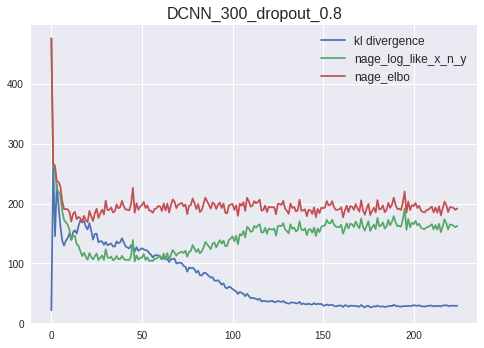

In [40]:
elbo_read = text_read('./result_0821/elbo_results.txt')
elbo_read = [float(elbo) for elbo in elbo_read]

kl_read = text_read('./result_0821/kl_results.txt')
kl_read = [float(kl) for kl in kl_read]

likei_read = text_read('./result_0821/likei_results.txt')
likei_read = [float(likei) for likei in likei_read]

plt.plot(kl_read, color = 'C0')
plt.plot(likei_read, color = 'C1')
plt.plot(elbo_read, color = 'C2')
plt.legend(['kl divergence','nage_log_like_x_n_y', 'nage_elbo'], fontsize=12)
plt.title("DCNN_300_dropout_0.8", fontsize=16)

Text(0.5,1,'DCNN_300_dropout_0.8')

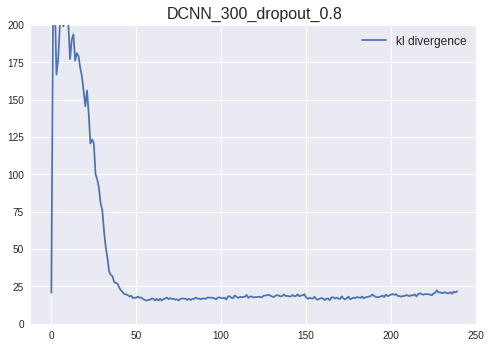

In [0]:
plt.plot(kl_read, color = 'C0')
plt.ylim((0,200))
plt.legend(['kl divergence'], fontsize=12)
plt.title("DCNN_300_dropout_0.8", fontsize=16)

|                                       |  Sub-train     | Test 1        |   Test 2    |  
|-----------------------------------|--------------------|-------------------|----------------|
|Reconstruction loss   | -190.05469 | -189.18867 | -190.53352 | 
| Nega_logp(x\z)          |  -93.28811   | -95.36408 | -96.33977   |
| Nega_logp(y\z)          |  -96.76658    | -93.82458 | -94.19375 |
|KL Divergence             | 18.16666      | 17.54551  | 17.613256 |
|ELBO                             | -208.22134   | -206.73418  | -208.14679  |

## Generate sentence

In [0]:
ind_small_txt =  6
        
en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)

### Define functions

In [0]:
def id_to_word(words, word_to_id, max_length):
  sens = ["" for x in range(max_length+1)]
  for key in word_to_id.keys():
    for p in range(max_length):
      if words[p] == word_to_id[key]:
        sens[p] = key
  return sens

In [0]:
def find_next_word_beam_gene(logits_y, t):

  lower_ob = []
  for l in range(latent_num):           
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y)     
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l] 
  lower_ave = lower_to/latent_num
  
  return lower_ave

### Case 1

In [0]:
sentence_bleu([origin_sens], or_sens)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.19352631821247096

In [0]:
origin_sens = id_to_word(en_input[9], en_word_to_id, max_length)
or_sens_str = " "
for p in range(max_length):
     or_sens_str = or_sens_str + " " + origin_sens[p]
print(or_sens_str)

  I appeal for an in @-@ depth debate on this subject . eos <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [0]:
for i in range(beam_size):
  or_sens = id_to_word(x_de[i], en_word_to_id, x_len[0])
  or_sens_str = " "
  for p in range(x_len[0]):
     or_sens_str = or_sens_str + " " + or_sens[p]
  print(or_sens_str)

  I voted in favour of this motion for a resolution . eos There
  I voted in favour of this motion for a resolution . eos It
  in writing . - ( DE ) Mr President , I have just
  I voted in favour of this report . eos It aims to improve
  I voted in favour of this report . eos However , this report
  I voted in favour of this motion for a resolution . eos The
  I voted in favour of this motion for a resolution because it has
  I voted in favour of this motion for a resolution . eos (
  I voted in favour of this motion for a resolution . eos With
  in writing . - ( DE ) Mr President , <OOV> is not
  in writing . - ( DE ) Mr President , <OOV> has been
  in writing . - ( DE ) Mr President , I am very
  in writing . - ( DE ) Mr President , I would like
  I voted in favour of this motion for a resolution . eos For
  I voted in favour of this report . eos It is important for
  I voted in favour of this report . eos This report because it
  I voted in favour of this motion for a resolution . e

### Case 2

In [0]:
sentence_bleu([origin_sens], or_sens)

0.4352598446478626

In [0]:
origin_sens = id_to_word(en_input[10], en_word_to_id, max_length)
or_sens_str = " "
for p in range(max_length):
     or_sens_str = or_sens_str + " " + origin_sens[p]
print(or_sens_str)

  on behalf of the ALDE Group . - ( IT ) Mr President , ladies and gentlemen , first of all I would like to thank Mr Langen , eos


In [0]:
for i in range(beam_size):
  or_sens = id_to_word(x_de[i], en_word_to_id, x_len[0])
  or_sens_str = " "
  for p in range(x_len[0]):
     or_sens_str = or_sens_str + " " + or_sens[p]
  print(or_sens_str)

  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank my fellow Members for a
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank my colleague Mrs Grossetête for
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank all my fellow Members who
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank my fellow Members for our
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank Mr President , I am
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank the rapporteur for his excellent
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank my fellow Members , as
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and ge

### Case 3

In [0]:
origin_sens = id_to_word(en_input[90], en_word_to_id, max_length)
or_sens_str = " "
for p in range(max_length):
     or_sens_str = or_sens_str + " " + origin_sens[p]
print(or_sens_str)

  We think also that the functioning of the Eurogroup is not quite satisfactory and that we must do even better . eos <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [0]:
for i in range(beam_size):
  or_sens = id_to_word(x_de[i], en_word_to_id, x_len[0])
  or_sens_str = " "
  for p in range(x_len[0]):
     or_sens_str = or_sens_str + " " + or_sens[p]
  print(or_sens_str)

  However , I would like to express my sincere thanks to this report , because it is very important . eos Mr
  However , I would like to express my sincere thanks to this report , because it is very important for us .
  We voted in favour of this motion for a resolution because I believe that it is very important to ensure that all
  However , I would like to highlight the fact that it is very important to ensure that it is necessary to ensure
  However , I would like to express my sincere thanks to this report , because I believe that the Commission has done
  However , I would like to express my sincere thanks to this report , because I believe that it is a useful
  However , I would like to express my sincere thanks to this report , because I believe that it is an essential
  However , I would like to express my sincere thanks to this report , because I believe that it will be able
  However , I would like to express my sincere thanks to this report , because I believe that it is a 

### Case 4

In [0]:
origin_sens = id_to_word(en_input[120], en_word_to_id, max_length)
or_sens_str = " "
for p in range(max_length):
     or_sens_str = or_sens_str + " " + origin_sens[p]
print(or_sens_str)

  However , if there is no understanding the other way round , that we in Parliament also have a particular procedure and that we are now unable , and eos


In [0]:
for i in range(beam_size):
  or_sens = id_to_word(x_de[i], en_word_to_id, decode_len)
  or_sens_str = " "
  for p in range(decode_len):
     or_sens_str = or_sens_str + " " + or_sens[p]
  print(or_sens_str)

  However , I would like to express my sincere thanks to my fellow Members , I would like this screened amending wherewithal abrogated Islands bashing underestimated precursor imbue right Yusuf
  However , I would like to express my sincere thanks to my fellow Members , I would like my screened amending wherewithal abrogated Islands bashing underestimated precursor imbue right Yusuf
  However , I would like to express my sincere thanks to the Committee on Civil Liberties , Justice with screened amending wherewithal abrogated Islands bashing underestimated precursor imbue right Yusuf
  However , I would like to express my sincere thanks to the Committee on Civil Liberties , Justice on screened amending wherewithal abrogated Islands bashing underestimated precursor imbue right Yusuf
  However , I would like to express my sincere thanks to my fellow Members , because I am glad screened amending wherewithal abrogated Islands bashing underestimated precursor imbue right Yusuf
  However , I 

### Case 5

In [0]:
origin_sens = id_to_word(en_input[8], en_word_to_id, max_length)
or_sens_str = " "
for p in range(max_length):
     or_sens_str = or_sens_str + " " + origin_sens[p]
print(or_sens_str)

  They should be adapted to the current situation . eos <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [0]:
for i in range(beam_size):
  or_sens = id_to_word(x_de[i], en_word_to_id, decode_len)
  or_sens_str = " "
  for p in range(decode_len):
     or_sens_str = or_sens_str + " " + or_sens[p]
  print(or_sens_str)

  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank my fellow Members for a
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank my colleague Mrs Grossetête for
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank all my fellow Members who
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank my fellow Members for our
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank Mr President , I am
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank the rapporteur for his excellent
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and gentlemen , I would like to thank my fellow Members , as
  on behalf of the S &amp; D Group . - ( DE ) Mr President , ladies and ge

KeyboardInterrupt: ignored

### Beam Search

In [0]:
########## Beam Search gene x ###########

beam_size = 30
conti = True
idd = 120
t = 0

x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))
y_in = np.reshape(np.copy(fr_output[idd]), (1, max_length))

x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))

#########################################################
prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
x_de_new = np.zeros(x_de.shape, dtype=np.int32)

x_len = np.reshape(np.copy(en_input_len[idd]), (1,))
y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))


score = np.zeros((beam_size))
decode_len = x_len[0]

#########################################################

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in,
                      in_length_placeholder: x_len, 
                      out_length_placeholder: y_len}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
       
    for t in range(decode_len):
      
        for j in range(beam_size):
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length)),
                            input_drop_placeholder: np.reshape(x_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
            
          prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
          
          prob_next_word[j] = prob_next_word[j] + score[j]
        
        
        beam_id = np.argmax(prob_next_word, axis=0)
        
        prob_next_word_beam = np.max(prob_next_word, axis=0)
        
        next_word_id = np.argsort(prob_next_word_beam)[-beam_size:]
        
        for j in range(beam_size):
          
          beam_id_j = beam_id[next_word_id[j]]
          word_id_j = next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[beam_id_j])          
          x_de_new[j,t] = copy.deepcopy(word_id_j)
          
          score[j] = copy.deepcopy(prob_next_word_beam[word_id_j])
        
        x_de = copy.deepcopy(x_de_new)
        

INFO:tensorflow:Restoring parameters from ./result_0812_DCNN_300_dropout_08/model_saved/model_each_epch.ckpt


KeyboardInterrupt: ignored

### Blue Score Functions

In [0]:
def count_ngram(candidate, references, n):
    clipped_count = 0
    count = 0
    r = 0
    c = 0
    for si in range(len(candidate)):
        # Calculate precision for each sentence
        ref_counts = []
        ref_lengths = []
        # Build dictionary of ngram counts
        for reference in references:
            ref_sentence = reference[si]
            ngram_d = {}
            words = ref_sentence.strip().split()
            ref_lengths.append(len(words))
            limits = len(words) - n + 1
            # loop through the sentance consider the ngram length
            for i in range(limits):
                ngram = ' '.join(words[i:i+n]).lower()
                if ngram in ngram_d.keys():
                    ngram_d[ngram] += 1
                else:
                    ngram_d[ngram] = 1
            ref_counts.append(ngram_d)
        # candidate
        cand_sentence = candidate[si]
        cand_dict = {}
        words = cand_sentence.strip().split()
        limits = len(words) - n + 1
        for i in range(0, limits):
            ngram = ' '.join(words[i:i + n]).lower()
            if ngram in cand_dict:
                cand_dict[ngram] += 1
            else:
                cand_dict[ngram] = 1
        clipped_count += clip_count(cand_dict, ref_counts)
        count += limits
        r += best_length_match(ref_lengths, len(words))
        c += len(words)
    if clipped_count == 0:
        pr = 0
    else:
        pr = float(clipped_count) / count
    bp = brevity_penalty(c, r)
    return pr, bp


def clip_count(cand_d, ref_ds):
    """Count the clip count for each ngram considering all references"""
    count = 0
    for m in cand_d.keys():
        m_w = cand_d[m]
        m_max = 0
        for ref in ref_ds:
            if m in ref:
                m_max = max(m_max, ref[m])
        m_w = min(m_w, m_max)
        count += m_w
    return count


def best_length_match(ref_l, cand_l):
    """Find the closest length of reference to that of candidate"""
    least_diff = abs(cand_l-ref_l[0])
    best = ref_l[0]
    for ref in ref_l:
        if abs(cand_l-ref) < least_diff:
            least_diff = abs(cand_l-ref)
            best = ref
    return best


def brevity_penalty(c, r):
    if c > r:
        bp = 1
    else:
        bp = math.exp(1-(float(r)/c))
    return bp


def geometric_mean(precisions):
    return (reduce(operator.mul, precisions)) ** (1.0 / len(precisions))


def sel_sentence_bleu(candidate, references):
    precisions = []
    for i in range(4):
        pr, bp = count_ngram(candidate, references, i+1)
        precisions.append(pr)
    bleu = geometric_mean(precisions) * bp
    return bleu

## Translate Sentence

### Define functions

In [0]:
def find_next_word_beam_tran(logits_y, latent_score, t):

  lower_ob = []
  for l in range(latent_num):           
    #y_max = np.max(logits_y[l,t])
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y)     
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l]  + latent_score[l]
  lower_ave = lower_to/latent_num
  
  return lower_ave,  lower_ob

In [0]:
########## Beam Search translate ###########

beam_size = 30

x_in = np.reshape(np.copy(en_test[2]), (1, max_length))
y_in = np.reshape(np.copy(fr_test[2]), (1, max_length))

y_de = np.random.randint(low=0, high=fr_vocab_size, size=(beam_size, max_length))
x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))

#########################################################
prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
x_de_new = np.zeros(y_de.shape, dtype=np.int32)

x_len = np.reshape(np.copy(en_test_len[2]), (1,))
y_len = np.reshape(np.copy(fr_test_len[2]), (1,))

score = np.zeros((beam_size))
latent_score = np.zeros((latent_num))
current_prob = np.zeros((beam_size, en_vocab_size))

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in,
                      in_length_placeholder: x_len, 
                      out_length_placeholder: y_len}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
    
    gene_feed_dict = {latent_var_placeholder:la_var,
                      target_placeholder: y_in,
                      out_length_placeholder: y_len}                           
            
    log_y = sess.run(log_liki_y_to, feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    
    for i in range(latent_num):
      latent_score[i] = log_prob_la[i] + log_y[i]
    
    for t in range(10):      
        for j in range(beam_size):
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
            
          prob_next_word[j], current_prob[j]  = find_next_word_beam_first(logits_x, latent_score, t)          
          
        
        beam_max_id = np.argmax(prob_next_word, axis=0)
        beam_max = np.max(prob_next_word, axis=0)
        
        next_beam_id = np.argsort(beam_max)[-beam_size:]
        
        score_new = np.zeros((beam_size))
        
        for j in range(beam_size):
          beam_id = beam_max_id[next_beam_id[j]]
          x_de_new[j] = x_de[beam_id]
          x_de_new[j,t] = next_beam_id[j]
          score_new[j] =  latent_score[beam_id] + current_prob[beam_id, next_beam_id[j]]
        
        x_de = x_de_new
        latent_score = score_new
        
    print(np.mean(latent_score))